# Predicting defaults on Lending Club database


- Authors: Beltrán Aller López and Miguel López Garralón
- Date: 13/12/2019
- Email: beltran.aller@cunef.edu and m.lopez@cunef.edu
- Institution: CUNEF
- Version: 1.0

In this notebook we have train the models with the dataset with the variables after doing the PCA reduction technique.

Before doing anything, we will import the necessaries libraries.

In [31]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt # plots
import seaborn as sns # plots
from scipy import stats as sts # normality test JB
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import Ridge, RidgeCV # Ridge
from sklearn.linear_model import Lasso, LassoCV # Lasso
from sklearn.linear_model import LogisticRegression # Log Regression
from sklearn.metrics import r2_score # R^2
from sklearn.model_selection import train_test_split # split data
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error # MSE
from sklearn.preprocessing import StandardScaler # estandarization
from sklearn import preprocessing # estandarization
from sklearn.ensemble import IsolationForest # outliers
from math import sqrt # sqrt
import itertools # aplanar arrays
import math
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC # SVM
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb # XGBOOST
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve # ROC Curve
from sklearn.datasets import make_classification
import random
random.seed(1122019)
import pickle

The following variable indicates the route in which we have our dataset.

In [32]:
data_path = '../data/PCA_set.csv'

## 1. READING THE DATA

The dataset is kept into the data directory. In the same folder you can find the data dictionary.

In [33]:
loan = pd.read_csv(data_path)

In [34]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950000 entries, 0 to 949999
Data columns (total 42 columns):
Component_1                            950000 non-null float64
Component_2                            950000 non-null float64
Component_3                            950000 non-null float64
Component_4                            950000 non-null float64
Component_5                            950000 non-null float64
Component_6                            950000 non-null float64
Component_7                            950000 non-null float64
Component_8                            950000 non-null float64
Component_9                            950000 non-null float64
Component_10                           950000 non-null float64
Component_11                           950000 non-null float64
Component_12                           950000 non-null float64
Component_13                           950000 non-null float64
Component_14                           950000 non-null float64
Compone

## 2. MODELING

In [35]:
X = loan.drop(['target'], axis = 1).values
Y = loan['target'].values

To do the logistic regression (and the other methods) we have to split the dataset into two parts, train and test. We know that the dataset is imbalanced, we have a lot of cases of non default and a few cases os default in comparisson. To solve that problem, we will apply a method of oversampling called Smote. Smote function creates synthetic samples of the minority class making the minority class equal to the majority class. To do that Smote selects similar records.

In [36]:
sm = SMOTE(random_state=40, sampling_strategy = 0.4)
X_train, Y_train = sm.fit_sample(X, Y)
print(X_train.shape); 

(1055384, 41)


Realise that we only do that over the train, the test must stay with the original distribution.

In [37]:
ytrain_df = pd.DataFrame(Y_train, columns = ['target'])

Here we can see the distribution of defaults and non defaults in the training set.

In [38]:
ytrain_df['target'].value_counts(normalize=True)

0    0.714286
1    0.285714
Name: target, dtype: float64

# Logistic Regression

Logistic regression is a statistical method for analyzing a dataset in which there are one or more independent variables that determine an outcome. The outcome is measured with a dichotomous variable (in which there are only two possible outcomes).

In [39]:
%%time
logit_loan = LogisticRegression(random_state=40, solver="saga", penalty="l1", class_weight="balanced", C=1.0, max_iter=500)
logit_loan.fit(X_train, Y_train)
logit_probs = logit_loan.predict_proba(X_train)
logit_scores = logit_probs[:,1]

Wall time: 7min 30s


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Once we have calculated our model, we will save it in order tu use it in the future. Due to we will need to save some models, we are going to make a function to not repeat the code as many times as models we will save.

In [40]:
def save_models(filename, model):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [41]:
save_models('../src/Models/WithPCA/logistic_regression', logit_loan)

# Support Vector Machine

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

We will do a grid search in order to find the optimus hyperparameters of our SVM.

In [42]:
%%time
param_test3 = {'C': [1, 10], 'kernel': ('linear', 'rbf')}
gsearch_SVM = GridSearchCV(estimator=SVC(max_iter = 1000),
             param_grid= param_test3 , scoring='roc_auc', n_jobs=-1, iid=False, cv=5)
gsearch_SVM.fit(X_train, Y_train)

C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Wall time: 8min 50s


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=1000,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=-1,
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

Here we have the best hyperparameters of our SVM.

In [43]:
gsearch_SVM.best_estimator_

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [44]:
%%time
gsearch_SVM2 = gsearch_SVM.best_estimator_
gsearch_SVM2.fit(X_train, Y_train)

Wall time: 57.2 s


C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
save_models('../src/Models/WithPCA/svm_regression', gsearch_SVM2)

# Random Forest

Random Forest, in this case, is a method for classification using an ensamble of many different decision trees. In this method the decision to classify in one class or in other comes frome making the mean of the results of all the decision trees. Random Forest has small variance and is difficult to have overfitting. We use this method because a unique decision tree is so unstable and, for that reason, we train the model with a lot of decision tress.

In [46]:
%%time
param_test1 = {
    'max_depth' : [4,8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
 }
gsearch_RandomForest = GridSearchCV(estimator = RandomForestClassifier(500), 
                               param_grid = param_test1, scoring='roc_auc',n_jobs=-1, iid=False, cv=3)
gsearch_RandomForest.fit(X_train, Y_train)

C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Wall time: 2h 7min 35s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=500, n_jobs=None,
                                              oob_score=False,
                                              rando

In [47]:
gsearch_RandomForest.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt'}

Here we have the best hyperparameters of our Random Forest model.

In [48]:
gsearch_RandomForest.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
%%time
gsearch_RandomForest2 = gsearch_RandomForest.best_estimator_
gsearch_RandomForest2.fit(X_train, Y_train)

Wall time: 33min 46s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[7.78323908e-04 1.45981795e-02 9.37153627e-03 4.21611408e-03
 6.14405523e-02 3.13132237e-03 2.08844106e-03 5.81149534e-02
 2.63497684e-01 6.04065420e-02 1.93123251e-02 6.35786331e-02
 2.91114841e-03 8.73886653e-04 5.48237965e-03 2.59374833e-03
 1.92537194e-03 1.02714854e-03 8.81648558e-04 6.19296981e-04
 4.78172366e-04 6.35112074e-02 6.08740515e-02 1.69461222e-03
 1.51724197e-03 3.33776272e-02 4.79608037e-03 3.03877134e-02
 2.56891216e-02 8.70489567e-03 1.49902664e-02 1.15129842e-02
 1.02717870e-03 1.82055589e-04 2.71333783e-05 7.55930751e-04
 1.06761818e-02 7.46293306e-04 7.97813954e-04 2.58539413e-03
 1.48818808e-01]


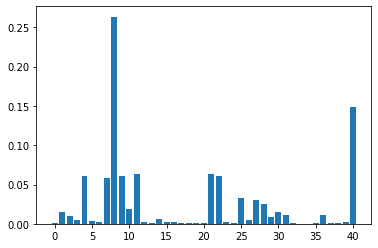

In [50]:
print(gsearch_RandomForest2.feature_importances_)

list(gsearch_RandomForest2.feature_importances_)

plt.bar(range(len(gsearch_RandomForest2.feature_importances_)), gsearch_RandomForest2.feature_importances_)
plt.show()

In [51]:
pd.DataFrame(gsearch_RandomForest2.feature_importances_, loan.drop('target', axis=1).columns, columns = ['Importance'])

,Importance
Component_1,0.000778
Component_2,0.014598
Component_3,0.009372
Component_4,0.004216
Component_5,0.061441
Component_6,0.003131
Component_7,0.002088
Component_8,0.058115
Component_9,0.263498
Component_10,0.060407


In [52]:
save_models('../src/Models/WithPCA/random_forest_regression', gsearch_RandomForest2)

# XGBoost

XGBoost is a method for classification similar to the Random Forest model, that uses an ensamble of many different decision trees. The difference with the Random Forest is that XGBoost has more variance, it could have problems with overfitting and it usually has more accuracy with less number of estimators. In this method the cases that have failed previously in their classification have more importance for the model, so they are used again in next samples to try to classify them correctly.

In [53]:
%%time
param_test2 = {
 'learning_rate':np.arange(0.1,1.0,0.2),
 'gamma': [0.5, 1, 1.5]
}
gsearch_XGBoost = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators=500, subsample=0.8,
                                                             colsample_bytree=0.8,objective= 'binary:logistic',
                                                             scale_pos_weight=1, seed=40, nthread = 6), 
                               param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=3)
gsearch_XGBoost.fit(X_train, Y_train)

C:\Users\Beltran\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Wall time: 1h 7min 54s


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=500, n_jobs=1,
                                     nthread=6, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=40, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'gamma': [0.5, 1, 1.5],
                         'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_trai

In [54]:
gsearch_XGBoost.best_params_

{'gamma': 1.5, 'learning_rate': 0.5000000000000001}

Here we have the best hyperparameters of our XGBoost Model.

In [55]:
gsearch_XGBoost.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.5000000000000001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=40,
              silent=None, subsample=0.8, verbosity=1)

In [56]:
%%time
gsearch_XGBoost2 = gsearch_XGBoost.best_estimator_
gsearch_XGBoost2.fit(X_train, Y_train)

Wall time: 2min 41s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.5000000000000001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=40,
              silent=None, subsample=0.8, verbosity=1)

[0.00187988 0.00795646 0.00741474 0.00144492 0.01195958 0.00497787
 0.00317727 0.01318608 0.02501114 0.00783249 0.00780602 0.01686233
 0.00357789 0.00345878 0.00553425 0.00093656 0.00239205 0.0014141
 0.00205197 0.00137554 0.00173059 0.05318944 0.01865996 0.06589431
 0.002276   0.1328337  0.00851709 0.03272313 0.19611403 0.04738036
 0.05260556 0.07673333 0.00531279 0.00877212 0.00491978 0.00125316
 0.06311008 0.00842844 0.01336852 0.00931577 0.06661192]


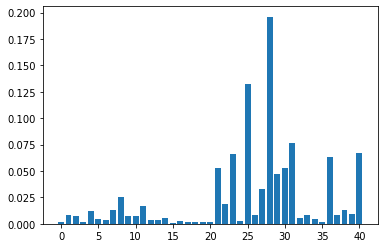

In [57]:
print(gsearch_XGBoost2.feature_importances_)

list(gsearch_XGBoost2.feature_importances_)

plt.bar(range(len(gsearch_XGBoost2.feature_importances_)), gsearch_XGBoost2.feature_importances_)
plt.show()

In [58]:
pd.DataFrame(gsearch_XGBoost2.feature_importances_, loan.drop('target', axis=1).columns, columns = ['Importance'])

,Importance
Component_1,0.001880
Component_2,0.007956
Component_3,0.007415
Component_4,0.001445
Component_5,0.011960
Component_6,0.004978
Component_7,0.003177
Component_8,0.013186
Component_9,0.025011
Component_10,0.007832


In [59]:
save_models('../src/Models/WithPCA/xgboost_regression', gsearch_XGBoost2)